<a href="https://colab.research.google.com/github/styxx216/EYES_TEST/blob/main/Eyes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import pandas
import torch
import torchvision
from torchvision import models, transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torch.nn.functional as F
import os
import cv2
import albumentations
from albumentations import pytorch as AT
import random
import pandas as pd

from sklearn.cluster import KMeans
import sklearn
from pathlib import Path
%matplotlib inline

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
BATH_SIZE = 8

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
PATH_TO_TRAIN_DATA = '/content/drive/MyDrive/TEST_TASK/train'
#PATH_TO_TRAIN_DATA='https://drive.google.com/uc?id=' + url.split('/')[-2]
url = 'https://drive.google.com/file/d/1ocYoFBuzQwVQu_XBes0x6IWkOlY7i9ww/view?usp=sharing'
PATH_TO_LABELS = 'https://drive.google.com/uc?id=' + url.split('/')[-2]

In [8]:
class dataset(Dataset):
    def __init__(self, path,transform=None):
        self.path = path
        self.transform = transform
    def __len__(self):
        res = len(os.listdir(self.path))
        return res
    def __getitem__(self,idx):
        path = os.path.join(self.path, os.listdir(self.path)[idx])
        image = cv2.imread(path,0)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        image = torch.tensor(image).float().to(device)
        image = torch.unsqueeze(image, 0)
        return image, path

In [9]:
class labeled_dataset(Dataset):
    def __init__(self, path,path_to_labels,transform=None):
        self.path = path
        self.transform = transform
        self.df = pd.read_csv(path_to_labels)
        self.df = self.df[self.df.marks.notnull()]
    def __len__(self):
        res = len(self.df)
        return res
    def __getitem__(self,idx):
        t = self.df.iloc[idx]
        path = os.path.join(self.path, t['pathes'])
        image = cv2.imread(path,0)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        image = torch.tensor(image).float().to(device)/255
        image = torch.unsqueeze(image, 0)
        label = t.marks
        return image, label

In [10]:
data_transformation = albumentations.Compose([
    albumentations.RandomBrightnessContrast(p=0.5),
    albumentations.HorizontalFlip()
    ])

In [11]:
img_set = labeled_dataset(PATH_TO_TRAIN_DATA,PATH_TO_LABELS, transform = data_transformation)

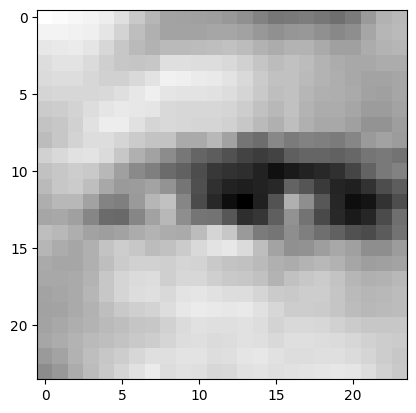

In [12]:
plt.imshow(img_set[0][0].cpu()[0], cmap = 'gray')

In [13]:
train_set, test_set = sklearn.model_selection.train_test_split(img_set,test_size=0.1)

In [14]:
trainloader = torch.utils.data.DataLoader(train_set, 
                                        batch_size=BATH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(test_set, 
                                        batch_size=1, shuffle=True)

In [15]:
class MyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_1 = torch.nn.Conv2d(1,8,kernel_size=5,padding=2)#[24,24,1]->[24,24,8]
        self.bn_1 = torch.nn.BatchNorm2d(8)
        self.conv_2 = torch.nn.Conv2d(8,16,kernel_size=5,padding=2)#[24,24,8]->[24,24,16]
        self.bn_2 = torch.nn.BatchNorm2d(16)
        self.pool = torch.nn.MaxPool2d(2,2)
        self.conv_3 = torch.nn.Conv2d(16,32,kernel_size=3,padding=1)#[12,12,16]->[12,12,32]
        self.bn_3 = torch.nn.BatchNorm2d(32)
        self.conv_4 = torch.nn.Conv2d(32,64,kernel_size=3,padding=1)#[12,12,32]->[12,12,64]
        self.bn_4 = torch.nn.BatchNorm2d(64)
        self.conv_5 = torch.nn.Conv2d(64,128,kernel_size=3,padding=1)#[6,6,64]->[6,6,128]
        self.bn_5 = torch.nn.BatchNorm2d(128)
        self.conv_6 = torch.nn.Conv2d(128,256,kernel_size=3,padding=1)#[6,6,128]->[6,6,256]
        self.bn_6 = torch.nn.BatchNorm2d(256)
        #[3,3,256]
        self.fc_1 = torch.nn.Linear(3*3*256, 1024)
        self.fc_2 = torch.nn.Linear(1024, 1)
    def forward(self,x):
        x = self.conv_1(x)
        x = self.bn_1(x)
        x = F.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv_3(x)
        x = self.bn_3(x)
        x = F.relu(x)
        x = self.conv_4(x)
        x = self.bn_4(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv_5(x)
        x = self.bn_5(x)
        x = F.relu(x)
        x = self.conv_6(x)
        x = self.bn_6(x)
        x = F.relu(x)
        x = self.pool(x)


        x = torch.flatten(x, 1)
        x = self.fc_1(x)
        x = torch.sigmoid(x)
        x = self.fc_2(x)
        x = torch.sigmoid(x)

        return x




In [16]:
class Encoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_1 = torch.nn.Conv2d(1,4,kernel_size=5,padding=2)#[24,24,1]->[24,24,4]
        self.bn_1 = torch.nn.BatchNorm2d(4)
        self.pool = torch.nn.MaxPool2d(2,2)
        self.conv_2 = torch.nn.Conv2d(4,8,kernel_size=3,padding=1)#[12,12,4]->[12,12,8]
        self.bn_2 = torch.nn.BatchNorm2d(8)
        self.conv_3 = torch.nn.Conv2d(8,16,kernel_size=3,padding=1)#[6,6,8]->[6,6,16]
        self.bn_3 = torch.nn.BatchNorm2d(16)
        
        self.dropout = torch.nn.Dropout()
    def forward(self,x):
        x = self.conv_1(x)
        x = self.bn_1(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.dropout(x)

        x = self.conv_2(x)
        x = self.bn_2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.dropout(x)

        x = self.conv_3(x)
        x = self.bn_3(x)
        x = F.relu(x)
        x = self.pool(x)
        return x
class TestModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()

        self.fc_1 = torch.nn.Linear(3*3*16, 512)
        self.fc_2 = torch.nn.Linear(512, 1)
        self.dropout = torch.nn.Dropout()
    def forward(self,x):
        x = self.encoder(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc_1(x)
        x = torch.sigmoid(x)
        x = self.dropout(x)
        x = self.fc_2(x)
        x = torch.sigmoid(x)

        return x
        

In [17]:
model =TestModel()
model = model.to(device)
criterion = torch.nn.BCEWithLogitsLoss()
n_epoch = 100
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=2)

In [18]:
def test_model(model,testloader):
  total = 0
  correct = 0
  with torch.no_grad():
      model.eval()
      for data, labels in testloader:
        labels=labels.to(device)
        data = data.to(device)
        outputs = model(data)
        predicted = torch.round(outputs)
        predicted=torch.reshape(predicted, (-1,))
        correct+=torch.eq(labels,predicted).sum()
        total+=len(labels)
                  
  accuracy = correct / total
  return accuracy

In [19]:
model.train()
train_loss = []
train_losses = []
train_acc = []
test_acc = []
max_acc = 0
for epoch in range(n_epoch):
    for i, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data).squeeze()
        loss = criterion(output, target)
        loss.backward()       
        optimizer.step()

        train_loss.append(loss.item())
    scheduler.step(np.mean(train_loss))
    current_test_acc = test_model(model,testloader)
    current_train_acc = test_model(model,trainloader)
    test_acc.append(current_test_acc)
    train_acc.append(current_train_acc)
    if current_test_acc > max_acc:
      max_acc = current_test_acc
      torch.save(model.state_dict(),'/content/drive/MyDrive/test_model.pth')
    print(f" Epoch: {epoch+1}, train loss: {np.mean(train_loss)}, learning rate: {optimizer.param_groups[0]['lr']} ")
    train_losses.append(np.mean(train_loss))


 Epoch: 1, train loss: 0.7032108985518547, learning rate: 0.0001 
 Epoch: 2, train loss: 0.6986077127848281, learning rate: 0.0001 
 Epoch: 3, train loss: 0.6962974155365422, learning rate: 0.0001 
 Epoch: 4, train loss: 0.6946268314211598, learning rate: 0.0001 
 Epoch: 5, train loss: 0.6929955466476996, learning rate: 0.0001 
 Epoch: 6, train loss: 0.6915010812348776, learning rate: 0.0001 
 Epoch: 7, train loss: 0.6894515936729418, learning rate: 0.0001 
 Epoch: 8, train loss: 0.686429057839179, learning rate: 0.0001 
 Epoch: 9, train loss: 0.6824148738841637, learning rate: 0.0001 
 Epoch: 10, train loss: 0.6777955284424168, learning rate: 0.0001 
 Epoch: 11, train loss: 0.6730622117206282, learning rate: 0.0001 
 Epoch: 12, train loss: 0.6685206599842545, learning rate: 0.0001 
 Epoch: 13, train loss: 0.6642151789842041, learning rate: 0.0001 
 Epoch: 14, train loss: 0.6601733274063133, learning rate: 0.0001 
 Epoch: 15, train loss: 0.6564865899982459, learning rate: 0.0001 
 Epoc

In [20]:
test_model(model,trainloader)

tensor(0.9432, device='cuda:0')

In [21]:
test_model(model,testloader)

tensor(0.9080, device='cuda:0')

In [22]:
test_acc = list(map(float,test_acc))
train_acc = list(map(float,train_acc))

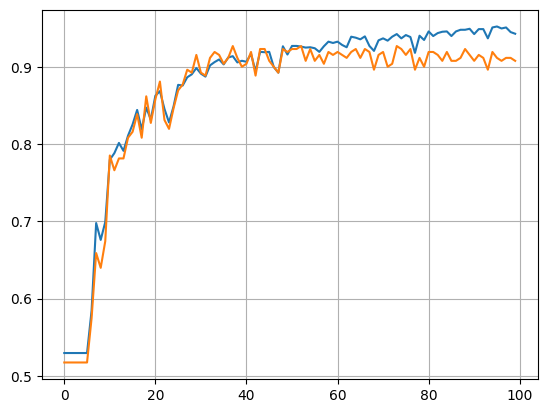

In [23]:
plt.plot(train_acc)
plt.plot(test_acc)
plt.grid(True)
plt.show()

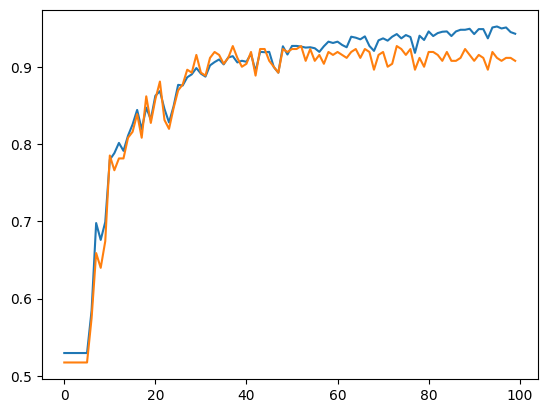

In [24]:
plt.plot(train_acc)
plt.plot(test_acc)
plt.show()

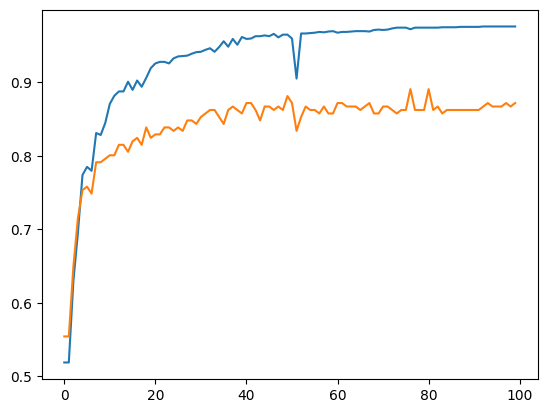

In [ ]:
plt.plot(train_acc)
plt.plot(test_acc)
plt.show()

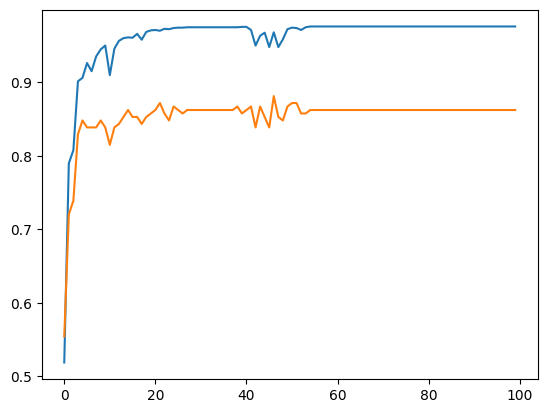

In [ ]:
plt.plot(train_acc)
plt.plot(test_acc)
plt.show()

Encoder(
  (conv_1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn_1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

SyntaxError: ignored

#Комбинация из feature extractor и K-means

In [26]:
model = models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 201MB/s]


In [59]:
class FeatureExtractor(torch.nn.Module):
  def __init__(self, model):
    super(FeatureExtractor, self).__init__()
    self.ad_pool = torch.nn.AdaptiveAvgPool2d(400)
    self.features = list(model.features)
    self.features = torch.nn.Sequential(*self.features)
    self.pooling = model.avgpool
    self.flatten = torch.nn.Flatten()
    self.fc = model.classifier[0]
  
  def forward(self, x):
    x = self.ad_pool(x)
    x = self.features(x)
    x = self.pooling(x)
    x = self.flatten(x)
    x = self.fc(x) 
    return x 


model = models.vgg16(pretrained=True)
new_model = FeatureExtractor(model)

new_model = new_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [72]:
features = []
labels = []

In [73]:
with torch.no_grad():
    model.eval()
    for data, label in testloader:
        data = torch.cat((data,data,data),1)
        data=data.to(device)

        f = new_model(data)
        features.append(f.cpu().detach().numpy().reshape(-1))
        labels.append(int(label.cpu().detach().numpy().reshape(-1)[0]))

In [77]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(features)
predicted = kmeans.labels_
print(predicted)
print(labels)
print((predicted == labels).sum()/len(labels))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[0 0 1 1 1 0 0 1 1 0 1 0 0 0 1 1 1 0 1 1 0 0 0 1 1 0 1 1 1 0 0 1 0 0 0 0 0
 1 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 1 1 0 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 1 0
 0 0 1 0 0 1 0 0 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 1 0 0 0 0 0
 0 0 1 0 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 1 0 1 0 1 0 0 1 1
 1 0 0 1 1 1 1 0 0 1 0 0 0 1 0 1 1 1 1 1 0 1 0 1 0 0 0 1 1 0 0 0 1 0 0 1 0
 1 1 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 1 1 1 0 1 1 0 1 1 1 1 0 1 0 1 1 0 1 1
 1 0 0 0 0 0 0 1 1 0 1 1 1 0 1 1 0 0 1 1 0 1 0 1 1 1 1 1 0 1 1 0 0 1 1 0 1
 0 0]
[1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 